### Data analysis for simulated traffic data
This document shows how to use existing data collected into Azure SQL database for basic data analysis. <br>
These instructions cover such topics as:
 - data preprocessing
 - pattern discovery through clustering 
 - pattern discovery through studying correlations between variables
 - forecasting traffic load

### Requirements
#### Required skills
The instructions require basic understanding of python programming language. Basis of statistics, linear algebra are optional requirements, which are needed for understanding the essence of the used algorithms. Knowing python is enough to finish the exercises, but mathematics is still needed for deep understaning of the presented topics. In general, basics from high school math should be enough for obtaining the intuition.
#### Exercises prerequisites
 - Azure account
 - Access to Azure SQL database with prestored data from the simulated traffic proccess
 - Access to jupyter notebooks (can be hosted either on local computer or on Azure)<br>
     __Note!__ It is possible to avoid using jupyter notebooks, just treat all the code from this document as one program

### Instructions

#### Preparing all required modules
As with almost any programing language, it is necessary to import all the used moduls/libraries. These exercices take use of the most common moduls for data analysis and plotting.
 - __pandas__ - this module provides very convenient data stracture, dataframe. Dataframes model table-like data and provide a lot of functionality for manipulated stored data.
 - __numpy__ - this module provides all of the required functionality for traditional numerical computing, from linear algebra to statistics. If you have experience with matlab, you will fill yourself at home. 
 - __pyodbc__ - database connector/bridge. It handles all connections to Azure SQL.
 - __matplotlib__ - this module is used for plotting. 
 - __sklearn__ - this module provides machine learning and statistical methods for data analysis
 - __datetime__ - this module provides datetime objects to store date and time in a format suitable for plotting 
<br>
<br>__Note!__ We do not import whole modules sometimes, as we only need small part of the functionality they provide, e.g. we only import certain methods from __sklearn__ and not the whole module.

In [1]:
import pandas as pd 
import numpy as np 
import pyodbc
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

#### Connecting to the database

Now that we have all the required modules ready, we can connect to the database. <br>
You can find all required information for connecting your database (if it is different from the one shown in the examples) on the database page from Azure portal. However, username and password should be mentioned separately. Initially your database only has admin account and under no circumstances should you use admin account for accessing your database from any application. <br>
In case you are not provided with prepared user, you will have to execute couple of queries in your database under admin user rights:
 1. __CREATE USER username WITH PASSWORD='password';__ Where __username__ and __password__ are of your choice. 
 2. __GRANT SELECT TO username;__ Where __username__ is from the previous query. This statement grants permission for executing __SELECT__ queries for the user. You should not grant any other permissions for that user, because even if this credentials are compromised, it will be impossible to do anything except for browsing the database.

In [2]:
server = 'aune.database.windows.net' # can be found from the overview page of the database
database = 'aune' # name of the database
username = 'jupyter' # name of the user you created or were given
password = 'abcd1234!@' # password for that user
# leave this string without changes. It configures a proper driver for Azure SQL database
driver = '{ODBC Driver 17 for SQL Server}' 
# MARS_Connection=Yes in the connection string allows to process results from several queries. 
con = 'Yes'
# bellow is the connection string, do not change it
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password + ';MARS_Connection=' + con) 

#### Quering and storing data from the database into pandas dataframe

In [3]:
table_name = 'dbo.traffic_sim' # name of the table with traffic data
query = 'SELECT * FROM ' + table_name; # prepare the query 
df = pd.read_sql(query, cnxn) # query db and store obtained data into pandas dataframe
# prints dimensions of the obtained data
print("Amount of rows: {}, Amount of columns: {}".format(df.shape[0], df.shape[1])) 
print("Top 5 rows:")
print(df.head(5)) # print top 5 rows

Amount of rows: 45019, Amount of columns: 5
Top 5 rows:
   id   location      speed  freq                    time
0   1  Junction1  27.600000   5.0 2019-05-06 08:40:35.720
1   2  Junction1  28.200001   4.0 2019-05-06 08:40:35.720
2   3  Junction2  24.700001   5.0 2019-05-06 08:40:35.720
3   4  Junction2  20.000000   4.0 2019-05-06 08:40:35.720
4   5  Junction1  18.900000   2.0 2019-05-06 08:40:35.720


#### Preprocessing
Now that we have all the data we need inside the dataframe, we can manipulate it in any way we might need. 
We don't have much to do with this dataset as it was simulated and it is already "clean" and almost ready to be analyses as it is, but we still can just couple of things:
 1. Plot obtained data. It is always important to visualize the data you are working with. It can show some defects in the data or obvious patterns.
 2. Scale the data to zero mean unit variance. Scaling usually improves performance of machine learning algorithms as it eliminates the need for outrageous parameters' values due to huge differences in variable values. That is not the case with this dataset, so it would be fine even without any scaling. So fill free to skip scaling if you want.
 3. Divide the dataset into separate once, based on location. 
 4. Get statistical description to see if we really need to divide the dataset, based on location

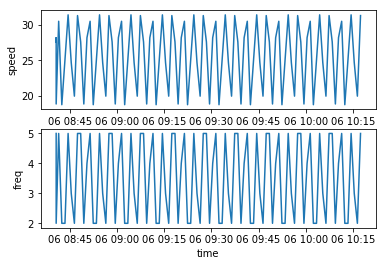

In [4]:
n_columns = 2 # only two columns are useful for plotting: speed and frequency
 # get list of junctions, it is used for dividing dataset into 3 based on location
junctions = df["location"].drop_duplicates().values
n_junctions = len(junctions) # amount of different locations
df_list = [] # list to hold of new datasets
for i in junctions:
    df_new = df[df["location"] == i] # separate by location
    df_new = df_new.reset_index()
    df_list.append(df_new) 

# plotting one of the junctions
n_measurements = 100 # select amount of measurements to plot
plt.subplot(2, 1, 1)
plt.plot(df_list[0]["time"][:n_measurements] ,df_list[0]["speed"][:n_measurements])
plt.xlabel("time")
plt.ylabel("speed")
plt.subplot(2, 1, 2)
plt.plot(df_list[0]["time"][:n_measurements], df_list[0]["freq"][:n_measurements])
plt.xlabel("time")
plt.ylabel("freq")
plt.show()
    


In [7]:
for i in range(n_junctions):
    print("Satistical description: Junction " + str(i + 1))
    print(df_list[i][['speed', 'freq']].describe())

Satistical description: Junction 1
              speed          freq
count  15007.000000  15007.000000
mean      25.650063      3.500033
std        4.737528      1.360212
min       18.799999      2.000000
25%       20.000000      2.000000
50%       27.600000      4.000000
75%       30.500000      5.000000
max       31.400000      5.000000
Satistical description: Junction 2
              speed          freq
count  15006.000000  15006.000000
mean      25.649787      5.500000
std        4.737411      1.360153
min       18.799999      4.000000
25%       20.000000      4.000000
50%       26.350000      5.500000
75%       30.500000      7.000000
max       31.400000      7.000000
Satistical description: Junction 3
              speed          freq
count  15006.000000  15006.000000
mean      25.649827      9.499867
std        4.737583      1.360202
min       18.799999      8.000000
25%       20.000000      8.000000
50%       25.100000      9.000000
75%       30.500000     11.000000
max       3

As it can be seen from the plot, there is a strong seasonality in the data. Later we will try to find out, what is the reason for that and how the variables are releated to each other. From statistical description we can say that speed comes from the same distribution for all of the locations, but it is not true for frequency. This implies that we need to consider these 3 datasets as different ones, what justifies our separation based on location.<br> 
Now we can proceede with scaling.


In [8]:
scalers = []
for i in range(n_junctions):
    scaler = StandardScaler()
    # scale dataframe
    df_list[i].loc[:, ['speed', 'freq']] = scaler.fit_transform(df_list[i][['speed', 'freq']].values) 
    scalers.append(scaler)

__Note!__ That we used 3 different scalers for 3 different datasets. As we have already seen from the statistical descriptions, we have different distributions for different locations, this makes it impossible to use the same scaler for all 3 datasets. However, if we had the same distribution for all of them, we would not have to fit 3 different scalers.  <br>


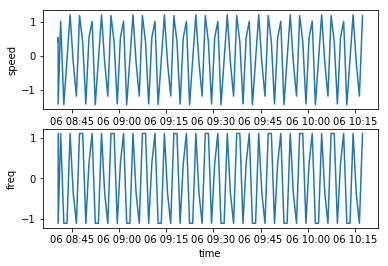

In [9]:
# plotting one of the junctions
n_measurements = 100 # select amount of measurements to plot
plt.subplot(2, 1, 1)
plt.plot(df_list[0]["time"][:n_measurements] ,df_list[0]["speed"][:n_measurements])
plt.xlabel("time")
plt.ylabel("speed")
plt.subplot(2, 1, 2)
plt.plot(df_list[0]["time"][:n_measurements], df_list[0]["freq"][:n_measurements])
plt.xlabel("time")
plt.ylabel("freq")
plt.show()

As it can be seen now we have most of our measurements in the range of -1 to 1 with 0 mean. That is rarely the case in real life situations due to some noise, disturbances or mixed distributions. However, we do have simulated data, obtained from only one distribution without much noise, therefore the scaling looks so nice. Also it is worth mentioning, that even though, we scaled the values, the patterns in speed and frequency remained the same. This condition always holds true to some extent, otherwise, it would be impossible to find any real life applications to scaling.

#### Correlation matrix
We will start with correlation matrix to build understanding on how frequency and speed relate to each other. <br>
Second part is to make time column into a categorical data type and find how frequency and speed change based on time. In general it is unreasonable to calculate correlation between time, if the change in variables is repeatable (seasonal) in respect to time, due to the nature of the correlations. Correlation magnitude shows how much one variable changes, then some other variable changes: when it changes in the simillar way (and by simillar amount) correlation is close to 1, if it changes in the opposit direction - correlation is close to -1. And finally, if the variable does not change at all, or changes in randomly with a change in some other variable, then they are uncorrelated, so correltion is 0. Based on all that, it is very hard to find correlations between numerical and non-numerical variables. That is why we are going to find basic statistical parameters based on time of the day.

In [10]:
for i in range(n_junctions):
    print("Correlation matrix for the Junction " + str(i + 1))
    print(df_list[i][['speed', 'freq']].corr())

Correlation matrix for the Junction 1
          speed      freq
speed  1.000000  0.911758
freq   0.911758  1.000000
Correlation matrix for the Junction 2
          speed      freq
speed  1.000000  0.911781
freq   0.911781  1.000000
Correlation matrix for the Junction 3
          speed      freq
speed  1.000000  0.911771
freq   0.911771  1.000000


As it can be seen from the correlation matrix, the relationships between speed and frequency are the same for all three locations. And it can be said, that in general, the higher the speed of the vehicle flow, the more vehicles cross the junctions. 

As a next step we need to define two functions in order to convert np.datetime64 object to python standard datetime (standard datetime allows us to extract only time from datetime) and then divide the time column into categories.

In [11]:
def nptime2datetime(time_arr):
    """
    Converts np.datetime64 to datetime objects
    Arguments:
        time_arr - list of np.datetime64 datetimes
    Returnes: 
        dt_list - list of datetimes 
    """
    str_list = [str(t) for t in time_arr]
    dt_list = [dt.datetime.strptime(t[:19], '%Y-%m-%dT%H:%M:%S') for t in str_list]
    return dt_list


In [12]:
def make_categories(time_arr):
    """
    Prepairs cetegories out of time variable. For example, all 
        the time from 8:00:00 to 8:59:00 makes one category and so on
    Arguments:
        time_arr - list with datetimes
    Returns:
        categories_list - list with categories
    """
    categories_list = []
    categories = {}
    for i in range(24):
        categories[str(i) + '-' + str(i+1)] = dt.time(hour=i, minute=59, second=59)
    
    for i in time_arr:
        for key, value in categories.items():
            if (i.time() <= value):
                categories_list.append(key)
                break
    return categories_list
    

    

In [13]:
for i in df_list:
    # get a list of datetimes
    dt_list = nptime2datetime(i["time"].values) 
    # convert the list into categories
    cats = make_categories(dt_list) 
    i["category"] = cats
# check if the catogory is added
print(df_list[0].head()) 

   index  id   location     speed      freq                    time category
0      0   1  Junction1  0.411608  1.102782 2019-05-06 08:40:35.720      8-9
1      1   2  Junction1  0.538260  0.367578 2019-05-06 08:40:35.720      8-9
2      4   5  Junction1 -1.424855 -1.102831 2019-05-06 08:40:35.720      8-9
3      9  10  Junction1  1.023761  1.102782 2019-05-06 08:41:23.490      8-9
4     12  13  Junction1 -1.445964 -1.102831 2019-05-06 08:42:23.517      8-9


Now that we have category column in our datasets, we can make same separation as we had for location column. After separating datasets we can calculate mean values, variances and other statistical properties to see how they change over time.

In [14]:
categories = df_list[0]["category"].drop_duplicates().values
df_stats_list = []
for i in df_list: # loop for iterating over all datasets
    stats_list = []
    for cat in categories: # loop for iterating over all time categories
        stats = {} # dictionary to hold stats
        df_new = i[i["category"] == cat] # separate by category
        stats["speed_mean"] = df_new["speed"].mean()
        stats["freq_mean"] = df_new["freq"].mean()
        stats["speed_std"] = df_new["speed"].std()
        stats["freq_std"] = df_new["freq"].std()
        # store 24 mean/std values for freq and speed (one per category)
        stats_list.append(stats) 
    # store stats for all 3 datasets
    df_stats_list.append(stats_list) 

Now we plot statistical parameters over categories for each dataset to see if they are actually different.

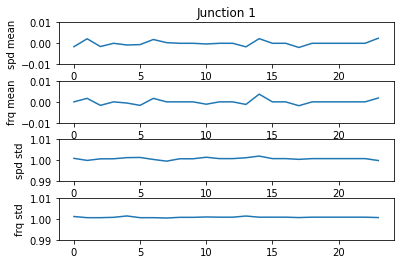

In [34]:
cat_num = [i for i in range(24)]

plt.subplot(4, 1, 1)
plt.title("Junction 1")
plt.plot(cat_num, [v["speed_mean"] for v in df_stats_list[0]])
plt.ylabel("spd mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 2)
plt.plot(cat_num, [v["freq_mean"] for v in df_stats_list[0]])
plt.ylabel("frq mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 3)
plt.plot(cat_num, [v["speed_std"] for v in df_stats_list[0]])
plt.ylabel("spd std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplot(4, 1, 4)
plt.plot(cat_num, [v["freq_std"] for v in df_stats_list[0]])
plt.ylabel("frq std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplots_adjust(hspace = 0.4)
plt.show()

This figure can be confusing in the beginning. Y-axis contains variable mean and standard deviation values for each category. X-axis - contains categories. The line represents how mean and standard deviation changes with the change in category (and don't forget that category here is obtained by grouping by hour) and so how these parameters change based on time, hour to say more precisely.

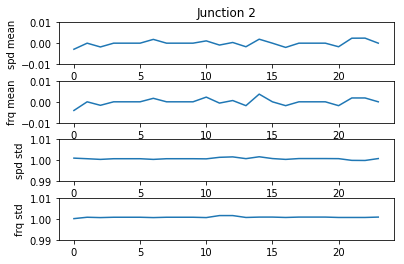

In [35]:
plt.subplot(4, 1, 1)
plt.title("Junction 2")
plt.plot(cat_num, [v["speed_mean"] for v in df_stats_list[1]])
plt.ylabel("spd mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 2)
plt.plot(cat_num, [v["freq_mean"] for v in df_stats_list[1]])
plt.ylabel("frq mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 3)
plt.plot(cat_num, [v["speed_std"] for v in df_stats_list[1]])
plt.ylabel("spd std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplot(4, 1, 4)
plt.plot(cat_num, [v["freq_std"] for v in df_stats_list[1]])
plt.ylabel("frq std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplots_adjust(hspace = 0.4)
plt.show()

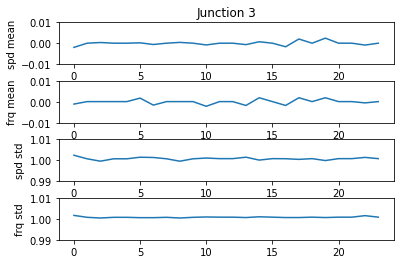

In [36]:
plt.subplot(4, 1, 1)
plt.title("Junction 3")
plt.plot(cat_num, [v["speed_mean"] for v in df_stats_list[2]])
plt.ylabel("spd mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 2)
plt.plot(cat_num, [v["freq_mean"] for v in df_stats_list[2]])
plt.ylabel("frq mean")
plt.ylim(top=0.01, bottom=-0.01)
plt.subplot(4, 1, 3)
plt.plot(cat_num, [v["speed_std"] for v in df_stats_list[2]])
plt.ylabel("spd std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplot(4, 1, 4)
plt.plot(cat_num, [v["freq_std"] for v in df_stats_list[2]])
plt.ylabel("frq std")
plt.ylim(top=1.01, bottom=0.99)
plt.subplots_adjust(hspace = 0.4)
plt.show()

As it can be seen from the plots, there is almost no difference between mean and std values with the change in category. Mean value is almost zero and standard deviation is very close to one all the time. <br>
__Note!__ You might want to skip scaling from previous sections to see real unscaled values. It does not change anything in the end, but it is nice to try just for better understanding of the scaling. 

The main conclusion we can make after analysing our dataset with the help from correlation matricies and usual statistical measures is that 3 junctions are only slightly different in how many cars per unit of time they allow to pass and there is no difference in the behavior of the junctions depending on the hour of the day. <br>
We could use this information for better planning our trips (now we know that it does not really matter at what time we go) or for better understanding results from other data analysis techniques. For example, clustering might be able to separate our data based on the location/junction, but not by time.

#### Clustering
We are going to use k-means clustering from sklearn in order to find underlying patterns in our data. We already got considerable understanding of our data from previous section, so now we can confirm our ideas about the dataset. It is always reassuring when you come to the same conclusion with different approaches.

For clustering we are going to use the whole scaled dataset. We have to switch from separate datasets, so we can easily differentiate between them.

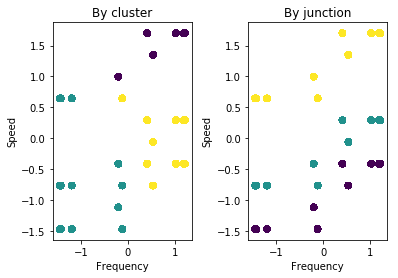

In [37]:
scaler = StandardScaler() 
# scale dataframe
df.loc[:, ['speed', 'freq']] = scaler.fit_transform(df[['speed', 'freq']].values) 
# initialize KMeans cluster algorithms, set amount of target clusters to 3
kmeans = KMeans(n_clusters=3) 
# we only use numerical features, it is trivial to cluster based on location anyway
c = kmeans.fit_predict(df[['speed', 'freq']])
# we convert kmeans labels to DataFrame so we can combine our dataset with labels
classes = pd.DataFrame(data=c, columns=['class'], index=df.index.values) 
# and here we actually combine them
classes_df = pd.concat([df, classes], axis=1) 
# matplotlib does not like strings as labels for coloring
df = df.replace({'Junction1':1, 'Junction2':2, 'Junction3':3})
plt.subplot(1,2,1)
plt.scatter(classes_df["speed"], classes_df["freq"], c=classes_df["class"])
plt.title("By cluster")
plt.xlabel("Frequency")
plt.ylabel("Speed")
plt.subplot(1,2,2)
plt.scatter(df["speed"], df["freq"], c=df["location"])
plt.title("By junction")
plt.xlabel("Frequency")
plt.ylabel("Speed")
plt.subplots_adjust(wspace = 0.4)
plt.show()

The figure on the left is clustering results, where color shows what cluster the point belongs to. On the left color shows what junction the point belongs to. 

k-Means clustering was not able to completely accurately differentiate between different junctions, but it does provide more or less accurate information. The reason for inaccuracies is that the date is very simillar in different locations, so it is hard for k-Means to separate it accurately. <br>
k-Means clustering is a very powerful tool for analyzing underlying patterns, but it is not a perfect one. It should be used with caution, you should always validate the results of your clustering.

#### Traffic load forecasting
Now we are going to build several regression models for speed and frequency for the next point based on previous __n__ points. We are going to build model only for 1 junction, but fill experiment and build models for other locations. It as simple as just using different datasets for training regressors.<br>
We are going to start with building our helper functions:
 - timeshift - this function will use shifting along time axis, so we can use timeseries data as usual multivariate data, so each timestamp essentially becomes a new column, instead of row
 - score_test - this function is used for testing the accuracy of our regressor, it iterates other all test examples and forecasts the next one for each of them. Then it plots both real values and predicted to see how different they are
 

In [40]:
def timeshift(data, n_in, n_out):
    """
    Shifts data along time axis in order to tranform 
        timeseries dataset into dataset suitable for supervised learning
    Arguments:
        - data - dataset to transform
        - n_in - number of lag observations as input
        - n_out - number of lag observations as output
    Returns:
        - x_train - input for future model training
        - y_train - output for future model training
        - x_test - input for future model validation
        - y_test - output for future model validation
    """
    df = data[['speed', 'freq']]
    n_vars = df.shape[1]
    cols, names = [], []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))
        # magic used for naming variables
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)] 
    # forecast sequence (t, t+1, ... , t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if (i == 0):
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    train_part = int(agg.shape[0] * 0.9925) # here we divide our dataset into training/testing parts. 
    # we have so many points that even after 99/1 division we still have enough points for testing
    # if we had real data, we would divide more evenly, 80/20 is very common
    
    x_train = agg.iloc[:train_part, :-1*n_vars]
    y_train = agg.iloc[:train_part, -1*n_vars:]
    x_test = agg.iloc[train_part:, :-1*n_vars]
    y_test = agg.iloc[train_part:, -1*n_vars:]
    
    return x_train, y_train, x_test, y_test

In [41]:
def score_test(clf, x, y, scaler=None):
    """
    Tests accuracy of the regressor
    Arguments:
        clf - trained regressor
        x - test data
        y - test labels
        scaler - scaler for the dataset, if provided returns 
            the dataset to original values for prettier visualisation
    Returns:
        plots figures
    """
    preds = clf.predict(x)
    y = y.values
    
    if (scaler != None):
        y = scaler.inverse_transform(y)
        preds = scaler.inverse_transform(preds)
    
    plt.subplot(2,1,1)
    plt.ylabel("speed")
    plt.xlabel("sample")
    plt.plot(preds[:,0], label="predicted")
    plt.plot(y[:,0], label="label")
    plt.legend()
    plt.subplot(2,1,2)
    plt.ylabel("freq")
    plt.xlabel("sample")
    plt.plot(preds[:,1], label="predicted")
    plt.plot(y[:,1], label="label")
    plt.legend()
    plt.show()


Now we are going to build and fit a model for our forecasting. We are going to use SVR. For more information visit this link: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html or just google it, there are plenty of great articles about SVR and its original SVM algorithms. <br>
SVR can only output one variable at a time, so we have to train to different regressors: one for predicting speed and another one for predicting frequency. MultiOutputRegressor takes care of that for us. Without it we would have to create two models and train them separately. MultiOutputRegressor does absolutely the same thing, but we just don't have to care about it.

In [42]:
x_train, y_train, x_test, y_test = timeshift(df_list[0], 30, 1) # prepapre dataset with predefined function
clf = MultiOutputRegressor(SVR(gamma='scale', C=1.0, epsilon=0.2)) # define regression model
clf.fit(x_train, y_train) # train

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=None)

In [203]:
print("R score for train set: {}".format(clf.score(x_train, y_train)))
print("R score for test set: {}".format(clf.score(x_test, y_test)))


R score for train set: 0.9815788617036261
R score for test set: 0.9825961881086658


R score indicates how well the regressor is able to predict the value. 1 being the best possible score. So we did quite well in this case. R score is quite simillar to correlation. You can think of it as a correlation between predicted result and true value (label).

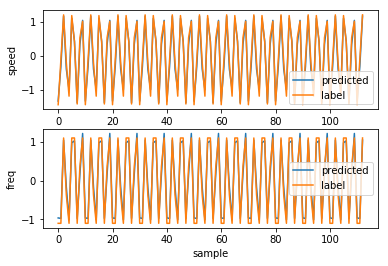

In [204]:
score_test(clf, x_test, y_test)

As you can see, predicted values and ground-truth values almost overlap, so our accuracy is indeed quite good. Lets now plot results after "descaling".

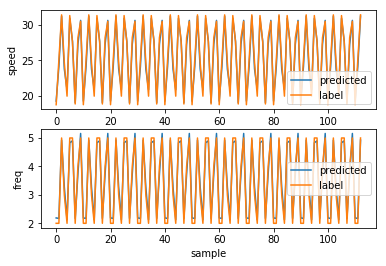

In [43]:
score_test(clf, x_test, y_test, scalers[0])

Even with original data our predictions are very closed to the labels. 

### Conclusion
After completing described steps you should get basic intuition about how data analysis works and its usual workflow. 
In most of the cases you have to do following steps in the provided order:
 1. Data Acquisition - in this case, you queried existing database.
 2. Data Preprocessing - here you have fixing missing values, scaling or reorganizing your data. Usually this is the most time consuming part. In these examples, you can consider scaling, making categories, reorganizing timeseries data into supervised type to be preprocessing. As you can see, preprocessing happens on different stages of the workflow.
 3. Analysis - here you study your dataset. Analysis includes a lot more than just building model and testing it, it also covers understanding your data - studying correlation matricies and clustering, for example. 
 4. Testing - scoring and visualising results from your models
 5. Deployment - usually you have to perform real time analysis with the model, so the model has to be deployed as a part of some application. This step is not covered in the exercises.
